## Analysis "Detection of cognitive low performers"

Here, we analyze and plot the results from classification of cognitive low performers, for the paper.

The configs to create the results which are analysed here are:
- `/src/data_analysis/configs/negative_outliers_norm/svc.yaml`
- `/src/data_analysis/configs/negative_outliers_norm/train_test/svc.yaml`

In [1]:
from distutils.core import setup

import pandas as pd
import numpy as np
import os
import json
import yaml
from collections import defaultdict
from sklearn import metrics as sk_metrics
from scipy.stats import spearmanr, pearsonr
from scipy.stats import bootstrap

from config.config import Config
from util.helpers import mean_absolute_percentile_error


In [3]:

# load directories from results dir that contain the results we're interested in
results_base_dir = [
    
'/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw14/20250404_0836_cc9b_svc_classification_cognitive_low_perf_norm',
'/Volumes/g_psyplafor_methlab$/Students/Jonathan/results/runs_luha/2025_kw14/20250404_0836_cc9b_svc_classification_cognitive_low_perf_norm_train_test',

]

results_dirs = [os.path.join(base) for base in results_base_dir if os.path.exists(os.path.join(base, "results.txt"))] + \
               [os.path.join(parent, dir) for base in results_base_dir for parent, dirs, _ in
                os.walk(os.path.join(base)) for dir in dirs if os.path.exists(os.path.join(parent, dir, "results.txt"))]


def calculate_test_union_scores(results_dir):
    with open(os.path.join(results_dir, 'predictions.json'), 'r') as f:
        predictions = json.load(f)
        predictions = np.array([val for split in predictions for val in split])
    with open(os.path.join(results_dir, 'true_labels.json'), 'r') as f:
        true_labels = json.load(f)
        true_labels = np.array([val for split in true_labels for val in split])
        
    return {'predictions': predictions, 'labels': true_labels}


def custom_sort(res_dir):
    if 'language' in res_dir:
        return 0
    elif 'executive_function' in res_dir:
        return 1
    elif 'speed' in res_dir:
        return 2
    else:
        return 3


scores = defaultdict(lambda: [])
dirs = defaultdict(lambda: [])

for d in sorted(results_dirs, key=custom_sort):
    # prepare data for results analysis
    # go through all results dirs, extract relevant information from e.g. config file, and condense them in parameter_string, which identifies a unique set of settings
    basename = os.path.basename(d)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))

    try:
        target = config.config_model.target_variable
    except:
        target = None

    try:
        task = config.config_data.task
    except:
        task = None

    try:
        data_transformers = "+".join(config.data_transformers)
        if 'Demographic Features' in config.data_transformers:
            demographic_feature_groups = ['dem']
        else: 
            demographic_feature_groups = []

        data_transformers = data_transformers.replace("Linguistic Features", "Ling")
        data_transformers = data_transformers.replace("Audio Features", "Audio")
        data_transformers = data_transformers.replace("Demographic Features", "Demogr")
    except:
        data_transformers = ""
        demographic_feature_groups = []
    
    try:
        data_preprocessors = "+".join(config.data_preprocessors)
        data_preprocessors = data_preprocessors.replace("Outlier Removal and Imputation", "OutlierRemoval")
        data_preprocessors = data_preprocessors.replace("Feature Standardizer", "Stand")
    except:
        data_preprocessors = ""   
        
    try:
        model_name = config.config_model.model_name
    except:
        model_name = None

    if 'Linguistic Features' in config.data_transformers:
        try:
            if not 'Linguistic Features' in config.data_transformers:
                raise ValueError(f"Invalid config: No Linguistic Features (data transformers: {data_transformers}) but ", config.config_linguistic_features.feature_groups, "for dir", d)
            linguistic_feature_groups = config.config_linguistic_features.feature_groups
        except:
            linguistic_feature_groups = ['literature_features', 'csunghye_features']
    else:
        linguistic_feature_groups = []
        
    if 'Audio Features' in config.data_transformers:
        try:
            if not 'Audio Features' in config.data_transformers:
                raise ValueError(f"Invalid config: No Audio Features (data transformers: {data_transformers}) but ", config.config_linguistic_features.feature_groups, "for dir", d)
            audio_feature_groups = config.config_audio_features.feature_groups
        except:
            audio_feature_groups = ['pause_features', 'phoneme_features', 'opensmile_features']
    else:
        audio_feature_groups = []

    try:
        cv_splits = config.config_model.cv_splits
    except:
        cv_splits = None
        
    try:
        data_split = config.config_data.split
    except:
        data_split = None
        
    feature_groups = audio_feature_groups + linguistic_feature_groups + demographic_feature_groups
    feature_group_mapping = {'pause_features': 'pause', 'phoneme_features': 'phoneme', 'opensmile_features': 'eGeMAPS', 'literature_features': 'lit', 'LIWC_features': 'liwc', 'csunghye_features': 'csunghye'}
    feature_groups = [feature_group_mapping.get(f, f) for f in feature_groups]
    feature_groups_str = "|".join(feature_groups)
    
            
    
    if data_split == 'full' and cv_splits == 1:
        setup_version = 'train/test'
    elif data_split == 'full' and (cv_splits is None or cv_splits > 1):
        setup_version = 'CV full'
    elif (data_split == 'train' or data_split is None) and (cv_splits is None or cv_splits > 1):
        setup_version = 'CV train'
    else:
        setup_version = "unknown"

        
    parameter_string = f"{model_name} - {task} - {target} - {data_transformers} - {data_preprocessors} - {setup_version} - {feature_groups_str}"

    dirs[parameter_string].append(d)

    
    scores[parameter_string].append(calculate_test_union_scores(d))



print(*[f"{parameter_string}: {len(scores[parameter_string])} results" for parameter_string in scores], sep="\n")

SVC - pictureDescription - composite_language - Ling+Audio+Demogr - OutlierRemoval+Stand - CV train - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_language - Ling+Audio+Demogr - OutlierRemoval+Stand - train/test - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_executive_function - Ling+Audio+Demogr - OutlierRemoval+Stand - CV train - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_executive_function - Ling+Audio+Demogr - OutlierRemoval+Stand - train/test - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_speed - Ling+Audio+Demogr - OutlierRemoval+Stand - CV train - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_speed - Ling+Audio+Demogr - OutlierRemoval+Stand - train/test - pause|phoneme|eGeMAPS|lit|csunghye|dem: 1 results
SVC - pictureDescription - composite_memory - Ling+Audio+Demogr - Ou

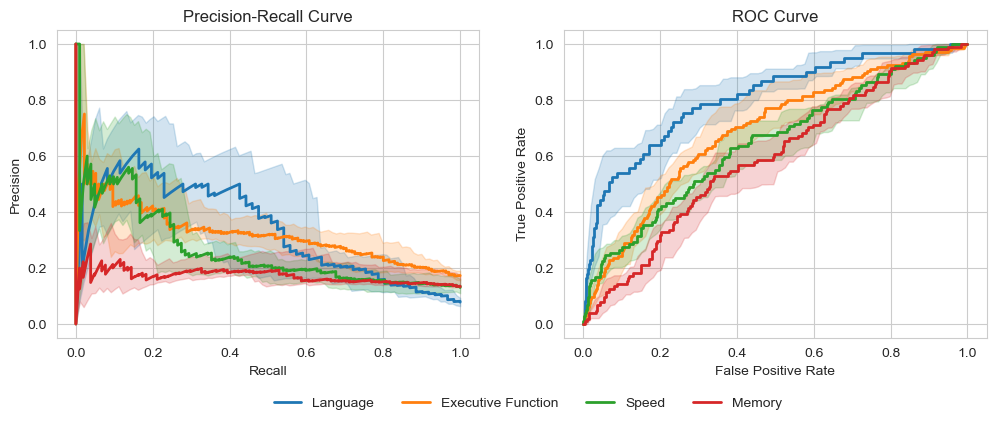

In [10]:
import seaborn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns


def plot_results(scores):
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    #colors = ['tab:green', 'tab:olive', 'tab:cyan', 'tab:blue', ]
    #colors = ['tab:red', 'tab:purple', 'tab:olive', 'tab:brown']
    
    target_string = {'composite_speed': 'Speed', 'composite_language': 'Language', 'composite_executive_function': 'Executive Function', 'composite_memory': 'Memory'}
    
    results = []
    plot_idx = 0
    for parameter_string, scores_here in scores.items(): 
        predictions = scores_here[0]['predictions']
        labels = scores_here[0]['labels']
        
        split_parameter_string = parameter_string.split(" - ")
        model_name, task, target, data_transformers, data_preprocessors, setup_version, feature_groups = split_parameter_string
    
        # Calculate the no skill line (proportion of positives)
        no_skill = np.sum(labels) / len(labels)
        #ax1.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='black', alpha=0.5)
    
        # Calculate precision-recall curve
        precisions, recalls, thresholds = metrics.precision_recall_curve(labels, predictions)
        pr_auc_score = metrics.auc(recalls, precisions)
        
        # Calculate the ROC curve and AUC score
        fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
        roc_auc = metrics.auc(fpr, tpr)

        # Bootstrapping for confidence intervals
        n_bootstraps = 10
        bootstrapped_scores_pr = []
        bootstrapped_pr_auc_scores = []
        bootstrapped_scores_roc = []
        bootstrapped_roc_auc_scores = []

    
        for i in range(n_bootstraps):
            # Bootstrap by sampling with replacement on the indices of the data
            indices = resample(np.arange(len(predictions)), replace=True)
            if len(np.unique(labels[indices])) < 2:
                # We need at least one positive and one negative sample for PR curve
                continue
    
            # precision-recall measures
            prc_precisions, prc_recalls, _ = metrics.precision_recall_curve(labels[indices], predictions[indices])
            pr_auc = metrics.auc(prc_recalls, prc_precisions)
            prc_precisions, prc_recalls = np.flip(prc_precisions), np.flip(prc_recalls)
            bootstrapped_scores_pr.append((prc_recalls, prc_precisions))
            bootstrapped_pr_auc_scores.append(pr_auc)
            
            # roc measures
            bs_fpr, bs_tpr, _ = metrics.roc_curve(labels[indices], predictions[indices])
            bs_auc = metrics.auc(bs_fpr, bs_tpr)
            bootstrapped_roc_auc_scores.append(bs_auc)
            bootstrapped_scores_roc.append((bs_fpr, bs_tpr))

    
        # Calculating 95% confidence intervals for precision-recall curve
        sorted_scores_pr = np.array([np.interp(np.linspace(0, 1, 100), prc_recalls, prc_precisions)
                                     for prc_recalls, prc_precisions in bootstrapped_scores_pr])
        sorted_scores_pr.sort(axis=0)
        lower_pr = sorted_scores_pr[int(0.025 * len(sorted_scores_pr)), :]
        upper_pr = sorted_scores_pr[int(0.975 * len(sorted_scores_pr)), :]

        
        # Interpolating all ROC curves to a common grid to calculate mean and CI
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, bs_fpr, bs_tpr) for bs_fpr, bs_tpr in bootstrapped_scores_roc], axis=0)
        tpr_lower = np.percentile([np.interp(mean_fpr, bs_fpr, bs_tpr) for bs_fpr, bs_tpr in bootstrapped_scores_roc], 2.5, axis=0)
        tpr_upper = np.percentile([np.interp(mean_fpr, bs_fpr, bs_tpr) for bs_fpr, bs_tpr in bootstrapped_scores_roc], 97.5, axis=0)

        
        # Calculating 95% confidence interval for AUC
        lower_pr_auc = np.percentile(bootstrapped_pr_auc_scores, 2.5)
        upper_pr_auc = np.percentile(bootstrapped_pr_auc_scores, 97.5)
        lower_roc_auc = np.percentile(bootstrapped_roc_auc_scores, 2.5)
        upper_roc_auc = np.percentile(bootstrapped_roc_auc_scores, 97.5)

        if setup_version == 'CV train':
            color = colors[plot_idx]
            
            # Plotting the mean precision-recall curve
            label = f"{target_string[target]}" #: AUC = {pr_auc_score:.2f} [{lower_pr_auc:.2f}-{upper_pr_auc:.2f}]"
            ax1.plot(recalls, precisions, label=label, lw=2, color=color)
            ax1.fill_between(np.linspace(0, 1, 100), lower_pr, upper_pr, color=color, alpha=0.2)
            
            # Plotting the mean ROC curve
            label = f"{target_string[parameter_string.split(' - ')[2]]}"#: AUC = {roc_auc:.2f} [{lower_roc_auc:.2f}-{upper_roc_auc:.2f}]"
            ax2.plot(fpr, tpr, label=label, lw=2, color=color)
            ax2.fill_between(mean_fpr, tpr_lower, tpr_upper, color=color, alpha=0.2)
            
            n = len(predictions)
            
            plot_idx += 1
        
        results_here = {
            'Cognitive Composite Score': target_string[target],
            'setup_version': setup_version.replace("CV train", "CV Developm set").replace("train/test", "Holdout Test set"),
            '\\# Samples': len(labels),
            '\\# Cognitive Low Performers': f"{np.sum(labels)} ({np.sum(labels) / len(labels) * 100:.1f}\\%)",
            'PR-AUC': f"{pr_auc_score:.2f} [{lower_pr_auc:.2f}-{upper_pr_auc:.2f}]" if setup_version == 'CV train' else f"{pr_auc_score:.2f}",
            'ROC-AUC': f"{roc_auc:.2f} [{lower_roc_auc:.2f}-{upper_roc_auc:.2f}]" if setup_version == 'CV train' else f"{roc_auc:.2f}",
        }
        results.append(results_here)

    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title(f'Precision-Recall Curve')  #  \nCV Development Set (n={n})
    ax1.legend(loc=(0.5, -0.25), ncol=4, frameon=False)
    
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'ROC Curve')  #  \nCV Development Set (n={n})
    #ax2.legend(loc="best")
    
    #plt.tight_layout()
    plt.savefig("plots/classification.pdf", bbox_inches='tight')
    plt.show()
    
    return pd.DataFrame(results)


    
results = plot_results(scores)

In [7]:
results

,Cognitive Composite Score,setup_version,\# Samples,\# Cognitive Low Performers,PR-AUC,ROC-AUC
0,Language,CV Developm set,783,61 (7.8\%),0.33 [0.26-0.44],0.81 [0.74-0.86]
1,Language,Holdout Test set,196,8 (4.1\%),0.09,0.75
2,Executive Function,CV Developm set,783,135 (17.2\%),0.32 [0.28-0.37],0.69 [0.66-0.72]
3,Executive Function,Holdout Test set,196,26 (13.3\%),0.23,0.61
4,Speed,CV Developm set,783,102 (13.0\%),0.26 [0.24-0.35],0.65 [0.61-0.70]
5,Speed,Holdout Test set,196,23 (11.7\%),0.21,0.69
6,Memory,CV Developm set,783,104 (13.3\%),0.17 [0.14-0.18],0.59 [0.55-0.63]
7,Memory,Holdout Test set,196,33 (16.8\%),0.19,0.58


In [8]:
results_pivoted = results.pivot(columns=['setup_version'], values=['\\# Samples', '\\# Cognitive Low Performers', 'PR-AUC', 'ROC-AUC'], index=['Cognitive Composite Score'])
results_pivoted

\# Samples                   \
setup_version             CV Developm set Holdout Test set   
Cognitive Composite Score                                    
Executive Function                    783              196   
Language                              783              196   
Memory                                783              196   
Speed                                 783              196   

                          \# Cognitive Low Performers                   \
setup_version                         CV Developm set Holdout Test set   
Cognitive Composite Score                                                
Executive Function                       135 (17.2\%)      26 (13.3\%)   
Language                                   61 (7.8\%)        8 (4.1\%)   
Memory                                   104 (13.3\%)      33 (16.8\%)   
Speed                                    102 (13.0\%)      23 (11.7\%)   

                                     PR-AUC                   \
setup_version               CV Developm set Holdout Test set   
Cognitive Composite Score                                      
Executive Function         0.32 [0.28-0.37]             0.23   
Language                   0.33 [0.26-0.44]             0.09   
Memory                     0.17 [0.14-0.18]             0.19   
Speed                      0.26 [0.24-0.35]             0.21   

                                    ROC-AUC                   
setup_version               CV Developm set Holdout Test set  
Cognitive Composite Score                                     
Executive Function         0.69 [0.66-0.72]             0.61  
Language                   0.81 [0.74-0.86]             0.75  
Memory                     0.59 [0.55-0.63]             0.58  
Speed                      0.65 [0.61-0.70]             0.69

In [9]:
print(results_pivoted.to_latex(index=True))

\begin{tabular}{lllllllll}
\toprule
 & \multicolumn{2}{r}{\# Samples} & \multicolumn{2}{r}{\# Cognitive Low Performers} & \multicolumn{2}{r}{PR-AUC} & \multicolumn{2}{r}{ROC-AUC} \\
setup_version & CV Developm set & Holdout Test set & CV Developm set & Holdout Test set & CV Developm set & Holdout Test set & CV Developm set & Holdout Test set \\
Cognitive Composite Score &  &  &  &  &  &  &  &  \\
\midrule
Executive Function & 783 & 196 & 135 (17.2\%) & 26 (13.3\%) & 0.32 [0.28-0.37] & 0.23 & 0.69 [0.66-0.72] & 0.61 \\
Language & 783 & 196 & 61 (7.8\%) & 8 (4.1\%) & 0.33 [0.26-0.44] & 0.09 & 0.81 [0.74-0.86] & 0.75 \\
Memory & 783 & 196 & 104 (13.3\%) & 33 (16.8\%) & 0.17 [0.14-0.18] & 0.19 & 0.59 [0.55-0.63] & 0.58 \\
Speed & 783 & 196 & 102 (13.0\%) & 23 (11.7\%) & 0.26 [0.24-0.35] & 0.21 & 0.65 [0.61-0.70] & 0.69 \\
\bottomrule
\end{tabular}

